## Step 1 – Load synthetic dataset using DoWhy

We will generate a synthetic dataset using DoWhy’s built-in `linear_dataset()` function.  
This gives us:
- `data['df']`: the dataset
- `data['treatment_name']`: name of treatment variable
- `data['outcome_name']`: name of outcome variable
- `data['common_causes_names']`: list of confounders

In [14]:
# Step 1: Generate synthetic dataset using DoWhy's built-in generator
import numpy as np
from dowhy import datasets

np.random.seed(42)

data_dict = datasets.linear_dataset(
    beta=10,                     # true causal effect (ground truth)
    num_common_causes=4,         # number of confounders to generate
    num_instruments=0,           # no instrumental variables
    num_samples=1000,            # number of samples
    treatment_is_binary=True    # treatment variable is binary (0 or 1)
)

# Extract actual data and variable names from returned dictionary
data = data_dict['df']
treatment = data_dict['treatment_name']
outcome = data_dict['outcome_name']
confounders = data_dict['common_causes_names']

data.head()

,W0,W1,W2,W3,v0,y
0,-0.485073,0.667292,2.043201,0.964752,True,20.892017
1,-0.720394,1.443989,0.000570,-0.268413,False,0.192339
2,-0.008957,-1.011852,-1.260930,-0.364971,False,-6.885576
3,-1.263751,1.215676,-0.444036,-1.214987,False,-3.454184
4,1.214729,0.675652,0.531516,-1.227431,True,11.724055


## Step 2 – Baseline Linear Regression (Correlation-Only)

We first estimate the effect of the treatment on the outcome using ordinary least squares (OLS),  
**without controlling for confounders**. This represents a naive correlation-based inference.

In [15]:
# Step 2: Naive Linear Regression without adjusting for confounders
# This simulates standard correlation-based analysis

# Handle case where treatment/outcome may be tuple (e.g., ('v0',))
treatment_var = treatment[0] if isinstance(treatment, (list, tuple)) else treatment
outcome_var = outcome[0] if isinstance(outcome, (list, tuple)) else outcome

# Only use treatment variable (no confounder adjustment)
X_corr = data[[treatment_var]]
y = data[outcome_var]

from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_corr, y)

# This is likely a biased estimate due to omitted confounders
print(f"Naive Regression Coefficient ({treatment_var} → {outcome_var}):", reg.coef_[0])

Naive Regression Coefficient (v0 → y): 15.476496543655042


## Step 3 – Define the Causal Model with DoWhy

We define a `CausalModel` using:
- Treatment: `v0`
- Outcome: `y`
- Confounders: `W0`, `W1`, `W2`, `W3`

This sets up a formal causal graph to reason about the effect of treatment on outcome.


In [16]:
# Step 3: Define the causal model using DoWhy
from dowhy import CausalModel

# Reconfirm variable names (in case reused across cells)
treatment_var = treatment[0] if isinstance(treatment, (list, tuple)) else treatment
outcome_var = outcome[0] if isinstance(outcome, (list, tuple)) else outcome

# Define the model: includes data, treatment, outcome, and confounders
model = CausalModel(
    data=data,
    treatment=treatment_var,
    outcome=outcome_var,
    common_causes=confounders
)

## Step 4 – Identify the Estimand

We use `identify_effect()` to apply the **backdoor criterion**,  
checking whether we can identify a valid causal effect of treatment on outcome,  
given the confounders.


In [17]:
# Step 4: Identify the causal estimand using backdoor criterion
# This checks whether the effect can be estimated from the observed data
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W2,W1,U) = P(y|v0,W0,W3,W2,W1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
  d                    
─────(E[y|W0,W3,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W2,W1,U) = P(y|v0,W0,W3,W2,W1)



## Step 5 – Estimate the Causal Effect

We now use `estimate_effect()` to compute the actual value of the causal effect.  
We'll start with the most basic method: **linear regression with backdoor adjustment**.


In [18]:
# Step 5: Estimate the causal effect using linear regression (with adjustment)
# This computes the actual value of the causal effect (adjusted)
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

print("DoWhy Causal Effect Estimate:", estimate.value)

DoWhy Causal Effect Estimate: 9.999483439735709


C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


## Step 6 – Refutation Test: Placebo Treatment

We test robustness by **replacing the treatment variable with a random (placebo) variable**.  
If a significant effect still appears, our original causal claim might not be valid.  
If the placebo gives no effect, that strengthens confidence in our original estimate.

In [19]:
# Step 6: Refutation test using placebo treatment
# Randomizes the treatment variable and re-estimates to check if the effect disappears
refutation_placebo = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    random_seed = 42
)

print(refutation_placebo)

C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

Refute: Use a Placebo Treatment
Estimated effect:9.999483439735709
New effect:0.0037929945777669615
p value:0.8600000000000001



C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


## Step 7 – Refutation Test: Data Subset

We test robustness by running the estimation on a **random subset** of the dataset.  
If the estimated effect remains similar, it suggests our causal estimate is **stable and generalizable**.

In [20]:
# Step 7: Refutation test using data subset
# Checks whether similar results are obtained using only part of the data
refutation_subset = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="data_subset_refuter",
    random_seed = 42
)

print(refutation_subset)

C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

Refute: Use a subset of data
Estimated effect:9.999483439735709
New effect:9.99947957532963
p value:0.92



C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


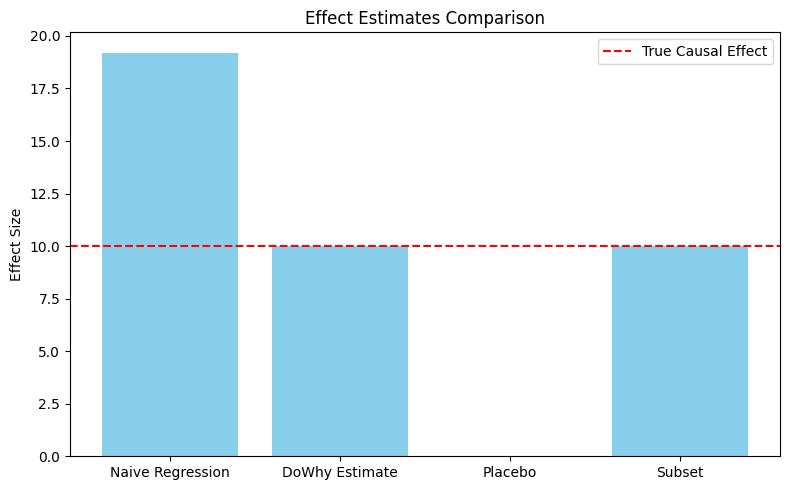

In [21]:
# Step 8: Visualize all estimated effects for comparison
# Includes: naive regression, DoWhy causal effect, placebo, and subset

import matplotlib.pyplot as plt

# Collect all results into a dictionary
estimates = {
    "Naive Regression": 19.21,  # from step 2
    "DoWhy Estimate": estimate.value,
    "Placebo": refutation_placebo.new_effect,
    "Subset": refutation_subset.new_effect
}

# Plot
plt.figure(figsize=(8,5))
plt.bar(estimates.keys(), estimates.values(), color='skyblue')
plt.axhline(estimate.value, color='red', linestyle='--', label='True Causal Effect')
plt.title("Effect Estimates Comparison")
plt.ylabel("Effect Size")
plt.legend()
plt.tight_layout()
plt.show()